In [1]:

#Import relevant libraries and define settings for plotting.#Import r 
from matplotlib.pyplot import *
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

#Avoid display of scientific notation and show precision of 4 decimals:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
df = pd.read_csv('C:/Users/shubhangipatil/Desktop/UBER/city_metrics.csv', parse_dates=['timestamp'], infer_datetime_format=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 5 columns):
timestamp               672 non-null datetime64[ns]
requests                672 non-null int64
trips                   672 non-null int64
supply_hours            672 non-null float64
mean_surge_multipler    672 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 26.3 KB


In [4]:
#There are 0 duplicated rows (this takes a while to run):
dup=len(df[df.duplicated() == True])
dup

0

In [5]:
#Checking null values
df.isnull().any() 

timestamp               False
requests                False
trips                   False
supply_hours            False
mean_surge_multipler    False
dtype: bool

In [6]:
#Parsing year, day, month and weekday in separate columns

df['Year'] = df.timestamp.dt.year
df['Month'] = df.timestamp.dt.month
df['Day'] = df.timestamp.dt.day
df['Weekday'] = df.timestamp.dt.dayofweek
df['Hour'] = df.timestamp.dt.hour

In [7]:
df.head()

,timestamp,requests,trips,supply_hours,mean_surge_multipler,Year,Month,Day,Weekday,Hour
0,2012-04-09 00:00:00,42,35,19.5000,1.0800,2012,4,9,0,0
1,2012-04-09 01:00:00,19,15,11.5000,1.0000,2012,4,9,0,1
2,2012-04-09 02:00:00,17,14,11.1000,1.0100,2012,4,9,0,2
3,2012-04-09 03:00:00,7,5,3.7000,1.0300,2012,4,9,0,3
4,2012-04-09 04:00:00,11,8,4.5000,1.2800,2012,4,9,0,4


In [8]:
#Descriptive statistics for numerical features:
df_viz=df[['requests', 'trips', 'supply_hours']].describe()
df_viz

,requests,trips,supply_hours
count,672.0000,672.0000,672.0000
mean,115.5565,98.1190,48.3878
std,72.2313,60.4110,27.7306
min,0.0000,0.0000,0.0000
25%,48.0000,41.0000,21.8250
50%,117.0000,101.5000,51.9000
75%,162.0000,137.0000,68.0250
max,350.0000,291.0000,120.4000


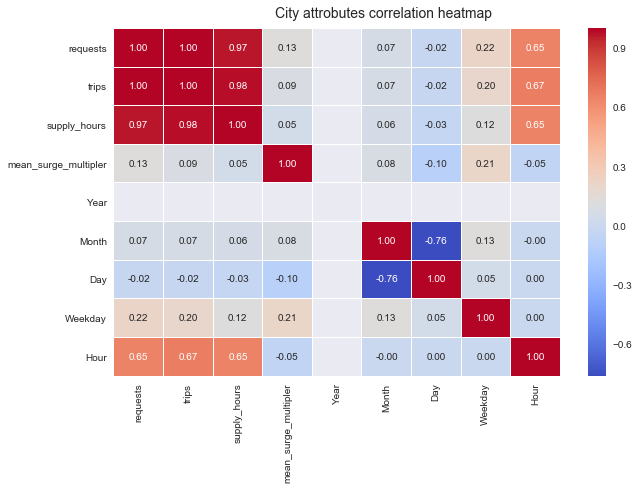

In [9]:
#Check for relationships among various attributes using pair-wise correlation matrix and a heatmap

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('City attrobutes correlation heatmap', fontsize=14)

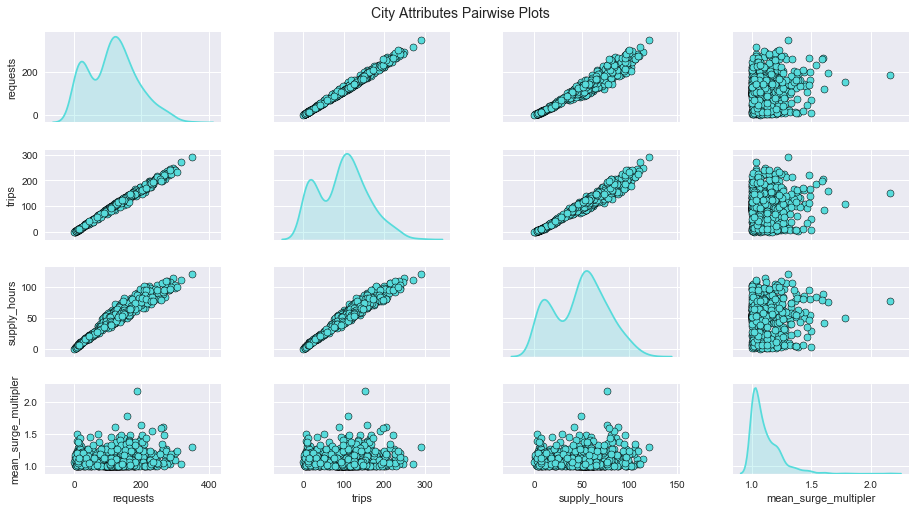

In [10]:
# Pair-wise Scatter Plots
cols = ['requests', 'trips', 'supply_hours', 'mean_surge_multipler']
pp = sns.pairplot(df[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('City Attributes Pairwise Plots', fontsize=14)

Text(0.5,1.05,'Trips given with requests and hour for the city')

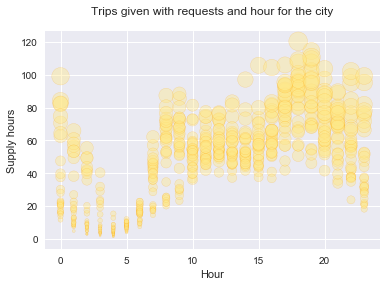

In [11]:
# Visualizing 4-D mix data using bubble plots
# leveraging the concepts of hue = trips and size=requests
size = df['requests']
fill_colors = ['#FF9999' if wt=='red' else '#FFE888' for wt in list(df['trips'])]
edge_colors = ['red' if wt=='red' else 'orange' for wt in list(df['trips'])]

plt.scatter(df['Hour'], df['supply_hours'], s=size,  alpha=0.4, color=fill_colors, edgecolors=edge_colors)

plt.xlabel('Hour')
plt.ylabel('Supply hours')
plt.title('Trips given with requests and hour for the city',y=1.05)

In [12]:
#Required by Plotly:
import matplotlib.mlab as mlab
import plotly.plotly as py

In [13]:
from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox) #Create image box
from matplotlib._png import read_png #Load png file
from matplotlib.patches import Ellipse #Draw ellipse

In [14]:
#Create functions to format tick numbers
def thousands_comma(x, pos):
    """
    Args are the value and tick position. 
    Returns number with thousands comma and no decimals.
    """
    return '{:,.0f}'.format(x) #this is the new syntax for formatting

In [15]:
def thousands_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with one decimal, and K in lieu of 3 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-3, 'K') #old syntax: '%1.0fK' % (x * 1e-3)

In [16]:
def thousands_currency(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with a $ sign, K in lieu of 3 zeros, and no decimals.
    """
    return '{:.0s}{}'.format('$', x * 1e-3, 'K')

In [17]:
#Define robust function to automatically add annotated labels on bar plots.
#Inspiration from http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
    return None

In [18]:
def is_peak_hour(x):
    """ 
    Function that takes an array(x) with two integers representing 
    hour of the day and weekday, respectively, and
    returns 1 if it's peak hour as defined, 0 otherwise.
    """
    return 1 if x[0] in (7,8,9,16,17,18) and x[1] < 5 else 0 #total peak hour periods = 6h

In [19]:
df['peak_hour'] = pd.Series(map(lambda x: is_peak_hour(x), df.loc[:, ['Hour', 'Weekday']].values))

In [20]:
df.head()

,timestamp,requests,trips,supply_hours,mean_surge_multipler,Year,Month,Day,Weekday,Hour,peak_hour
0,2012-04-09 00:00:00,42,35,19.5000,1.0800,2012,4,9,0,0,0
1,2012-04-09 01:00:00,19,15,11.5000,1.0000,2012,4,9,0,1,0
2,2012-04-09 02:00:00,17,14,11.1000,1.0100,2012,4,9,0,2,0
3,2012-04-09 03:00:00,7,5,3.7000,1.0300,2012,4,9,0,3,0
4,2012-04-09 04:00:00,11,8,4.5000,1.2800,2012,4,9,0,4,0


In [21]:
#Create dataframe with grouped data.
df_viz = df.groupby('Hour')['requests'].mean() #used median since distribution is skewed.

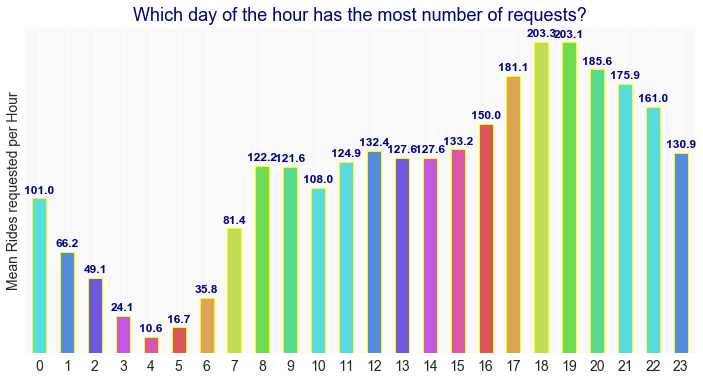

In [22]:
#Create plot. Does Friday have better traffic flow than Sunday?

fig = plt.figure()
labels_list = df_viz.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_viz.plot(kind='bar', rot = 0, figsize = (12, 6), fontsize = 12, edgecolor='yellow', linewidth=1)
#ax.set_xticklabels(weekday_labels, weight='bold')
ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('')
plt.ylabel('Mean Rides requested per Hour', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the hour has the most number of requests?', fontsize = 18, color='navy')
plt.show()
#plot_url = py.plot_mpl(fig)

In [23]:
df_viz1 = df.groupby('Hour')['trips'].mean()

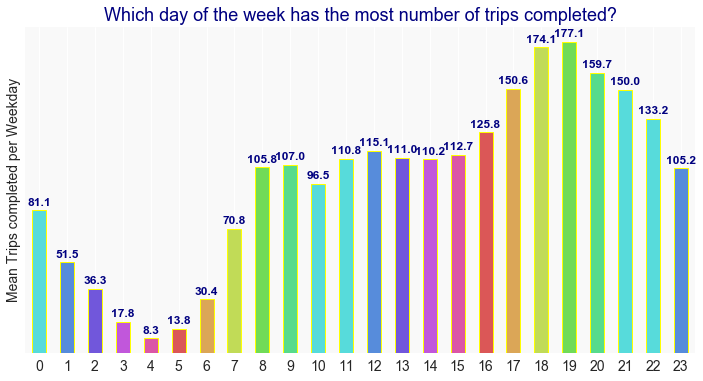

In [24]:
#Create plot. Does Friday have better traffic flow than Sunday?

fig = plt.figure()
labels_list = df_viz1.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_viz1.plot(kind='bar', rot = 0, figsize = (12, 6), fontsize = 12, edgecolor='yellow', linewidth=1)
#ax.set_xticklabels(weekday_labels, weight='bold')
ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('')
plt.ylabel('Mean Trips completed per Weekday', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the week has the most number of trips completed?', fontsize = 18, color='navy')
plt.show()
#plot_url = py.plot_mpl(fig)

In [25]:
df_viz2 = df.groupby(['Hour','requests'])['mean_surge_multipler']

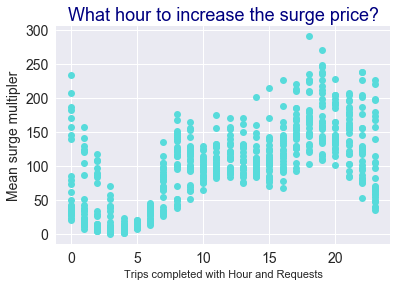

In [26]:

fig = plt.figure()
labels_list = df_viz2.apply
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

#ax = df_viz2.plot(kind='scatter', rot = 0, figsize = (12, 6), fontsize = 12, linestyle='none', marker='o')

ax=plt.plot( 'Hour', 'trips', data=df, linestyle='none', marker='o')

#ax.set_xticklabels(weekday_labels, weight='bold')
#ax.set_facecolor('#F9F9F9')
#ax.get_yaxis().set_ticks([])
#annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('Trips completed with Hour and Requests')
plt.ylabel('Mean surge multipler', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('What hour to increase the surge price?', fontsize = 18, color='navy')
plt.show()
#plot_url = py.plot_mpl(fig)

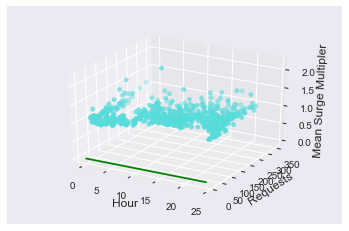

In [27]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for a three-dimensional line
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 4, 1)
xline = np.linspace(0, 24, 10)
yline = np.linspace(-3, 3, 10)
ax.plot3D(xline, yline, zline, 'green')

#threedee = plt.figure().gca(projection='3d')
#threedee.scatter(df['Hour'], df['requests'], df['mean_surge_multipler'],cmap='Greens')
ax.scatter3D(df['Hour'], df['requests'], df['mean_surge_multipler'], cmap='Greens');
ax.set_xlabel('Hour',fontsize = 12)
ax.set_ylabel('Requests',fontsize = 12)
ax.set_zlabel('Mean Surge Multipler',fontsize = 12)
ax.dist=12
plt.show()

In [28]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)
N = 20
x = np.linspace(0, 1, N)
y = np.abs(np.random.randn(N))


data = [
    go.Scatter(
        x=df['Hour'], # assign x as the dataframe column 'x'
        y=df['requests']
       # orientation='h',
    )
]

plotly.offline.iplot(data)
# IPython notebook
# py.iplot(data, filename='pandas-horizontal-bar')

#url = py.plot(data, filename='pandas-horizontal-bar')

In [29]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

plotly.offline.init_notebook_mode(connected=True)


# Create a trace
trace = go.Scattergl(
    x = df['Hour'],
    y = df['requests'],
    mode = 'markers',
    marker=dict(
        size='16',
        color = df['mean_surge_multipler'], #set color equal to a variable
        colorscale='Viridis',
        showscale=True,
    )
)

data = [trace]

# Plot and embed in ipython notebook!
#py.iplot(data, filename='basic-scatter')
plotly.offline.iplot(data)
